In [121]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns   
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import optuna
from optuna.pruners import MedianPruner
from catboost import Pool
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


In [71]:
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)

In [72]:

train_feat = pd.read_csv("data/training_set_features.csv")
train_target = pd.read_csv("data/training_set_labels.csv")
df = pd.merge(train_feat, train_target, on="respondent_id")
del(train_feat, train_target)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [74]:
df.isna().sum() / df.shape[0] * 100

respondent_id                   0.000
h1n1_concern                    0.344
h1n1_knowledge                  0.434
behavioral_antiviral_meds       0.266
behavioral_avoidance            0.779
behavioral_face_mask            0.071
behavioral_wash_hands           0.157
behavioral_large_gatherings     0.326
behavioral_outside_home         0.307
behavioral_touch_face           0.479
doctor_recc_h1n1                8.088
doctor_recc_seasonal            8.088
chronic_med_condition           3.636
child_under_6_months            3.070
health_worker                   3.010
health_insurance               45.958
opinion_h1n1_vacc_effective     1.464
opinion_h1n1_risk               1.453
opinion_h1n1_sick_from_vacc     1.479
opinion_seas_vacc_effective     1.730
opinion_seas_risk               1.925
opinion_seas_sick_from_vacc     2.011
age_group                       0.000
education                       5.268
race                            0.000
sex                             0.000
income_pover

In [75]:
# clearing dataframe from trash columns that mostly filled with NaNs
feat_nan_tresh = 0.2 # all feature columns with more than 20% NaNs will be deleted
tresh_columns = [col for col in df.columns if df[col].isna().sum() / df.shape[0] >= feat_nan_tresh]
df.drop(columns=tresh_columns, inplace=True)
tresh_columns

['health_insurance', 'employment_industry', 'employment_occupation']

In [76]:
# now it's slightly better
df.isna().sum() / df.shape[0] * 100

respondent_id                   0.000
h1n1_concern                    0.344
h1n1_knowledge                  0.434
behavioral_antiviral_meds       0.266
behavioral_avoidance            0.779
behavioral_face_mask            0.071
behavioral_wash_hands           0.157
behavioral_large_gatherings     0.326
behavioral_outside_home         0.307
behavioral_touch_face           0.479
doctor_recc_h1n1                8.088
doctor_recc_seasonal            8.088
chronic_med_condition           3.636
child_under_6_months            3.070
health_worker                   3.010
opinion_h1n1_vacc_effective     1.464
opinion_h1n1_risk               1.453
opinion_h1n1_sick_from_vacc     1.479
opinion_seas_vacc_effective     1.730
opinion_seas_risk               1.925
opinion_seas_sick_from_vacc     2.011
age_group                       0.000
education                       5.268
race                            0.000
sex                             0.000
income_poverty                 16.561
marital_stat

In [77]:
df.drop(columns=["respondent_id"], inplace=True)
df.dropna(inplace=True)
df.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19642 entries, 0 to 26706
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 19642 non-null  float64
 1   h1n1_knowledge               19642 non-null  float64
 2   behavioral_antiviral_meds    19642 non-null  float64
 3   behavioral_avoidance         19642 non-null  float64
 4   behavioral_face_mask         19642 non-null  float64
 5   behavioral_wash_hands        19642 non-null  float64
 6   behavioral_large_gatherings  19642 non-null  float64
 7   behavioral_outside_home      19642 non-null  float64
 8   behavioral_touch_face        19642 non-null  float64
 9   doctor_recc_h1n1             19642 non-null  float64
 10  doctor_recc_seasonal         19642 non-null  float64
 11  chronic_med_condition        19642 non-null  float64
 12  child_under_6_months         19642 non-null  float64
 13  health_worker        

In [79]:
df.head(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0
5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,atmpeygn,"MSA, Principle City",2.0,3.0,0,0


In [80]:
df['behavioral_antiviral_meds'].value_counts()

behavioral_antiviral_meds
0.0    18671
1.0      971
Name: count, dtype: int64

In [81]:
# finding binary columns in dataset
binary_cols = [col for col in df.columns if \
                df[col].dtype != 'bool' and \
                df[col].nunique() == 2 and \
                sorted(df[col].unique().tolist()) == [0, 1]]
df[binary_cols] = df[binary_cols].astype(bool)
df[binary_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 19642 entries, 0 to 26706
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   behavioral_antiviral_meds    19642 non-null  bool 
 1   behavioral_avoidance         19642 non-null  bool 
 2   behavioral_face_mask         19642 non-null  bool 
 3   behavioral_wash_hands        19642 non-null  bool 
 4   behavioral_large_gatherings  19642 non-null  bool 
 5   behavioral_outside_home      19642 non-null  bool 
 6   behavioral_touch_face        19642 non-null  bool 
 7   doctor_recc_h1n1             19642 non-null  bool 
 8   doctor_recc_seasonal         19642 non-null  bool 
 9   chronic_med_condition        19642 non-null  bool 
 10  child_under_6_months         19642 non-null  bool 
 11  health_worker                19642 non-null  bool 
 12  h1n1_vaccine                 19642 non-null  bool 
 13  seasonal_vaccine             19642 non-null  bool 


In [82]:
df['chronic_med_condition'].value_counts()

chronic_med_condition
False    14066
True      5576
Name: count, dtype: int64

In [83]:
# now deal with categorical variables
df.dtypes[df.dtypes == 'O']

age_group            object
education            object
race                 object
sex                  object
income_poverty       object
marital_status       object
rent_or_own          object
employment_status    object
hhs_geo_region       object
census_msa           object
dtype: object

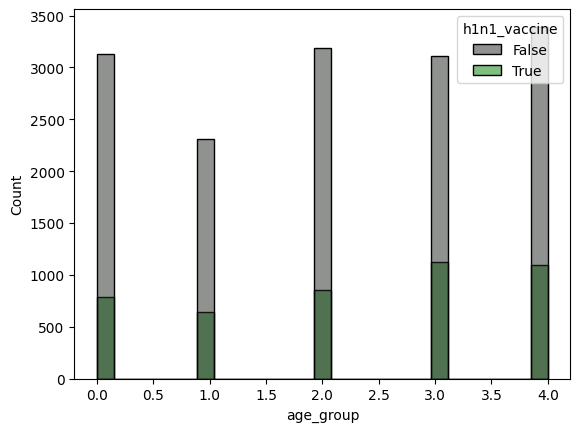

In [84]:
age_map = {
    "18 - 34 Years": 0,
    "35 - 44 Years": 1,
    "45 - 54 Years": 2,
    "55 - 64 Years": 3,
    "65+ Years": 4
}
df.age_group = df.age_group.map(age_map)
sns.histplot(df, x="age_group", hue="h1n1_vaccine", palette='dark:green');

In [85]:
df['age_group']


0        3
1        1
3        4
4        2
5        4
        ..
26700    3
26701    0
26702    4
26703    0
26706    4
Name: age_group, Length: 19642, dtype: int64

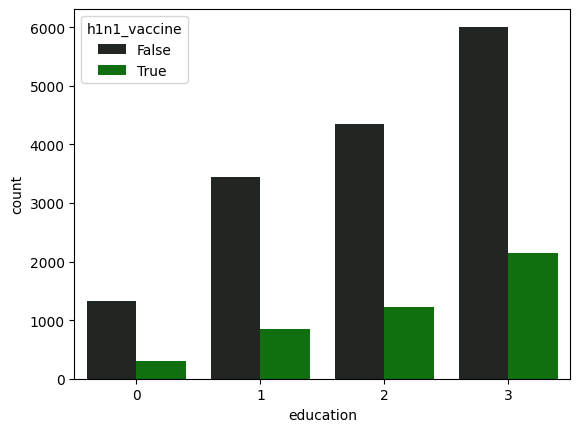

In [86]:
college_map = {
    "< 12 Years": 0,
    "12 Years": 1,
    "Some College": 2,
    "College Graduate": 3
}
df.education = df.education.map(college_map)
sns.countplot(df, x="education", hue='h1n1_vaccine', palette='dark:green');

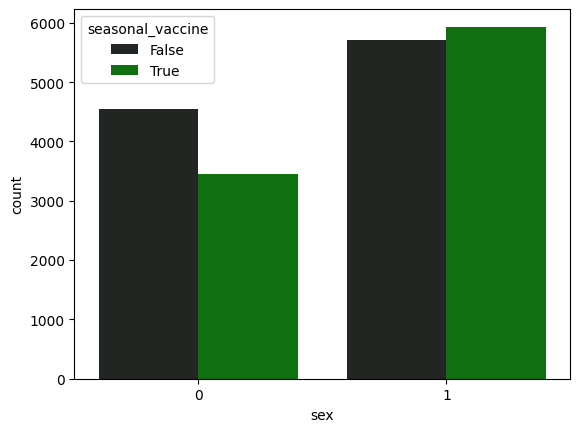

In [87]:
sex_map = {
    "Male": 0,
    "Female": 1
}
df.sex = df.sex.map(sex_map)
sns.countplot(df, x="sex", hue='seasonal_vaccine', palette='dark:green');

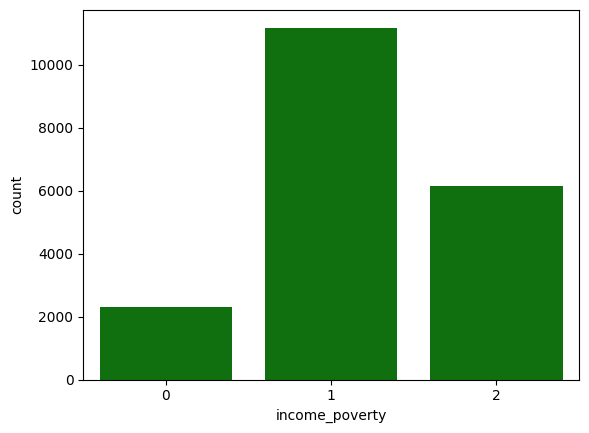

In [88]:
poverty_map = {
    "Below Poverty": 0,
    "<= $75,000, Above Poverty": 1,
    "> $75,000": 2
}
df.income_poverty = df.income_poverty.map(poverty_map)
sns.countplot(df, x="income_poverty", color='green');

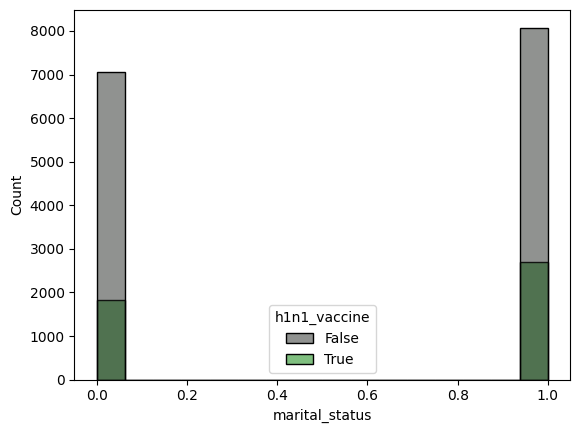

In [89]:
marital_map = {
    "Not Married": 0,
    "Married": 1
}
df.marital_status = df.marital_status.map(marital_map)
sns.histplot(df, x="marital_status", hue='h1n1_vaccine', palette='dark:green');

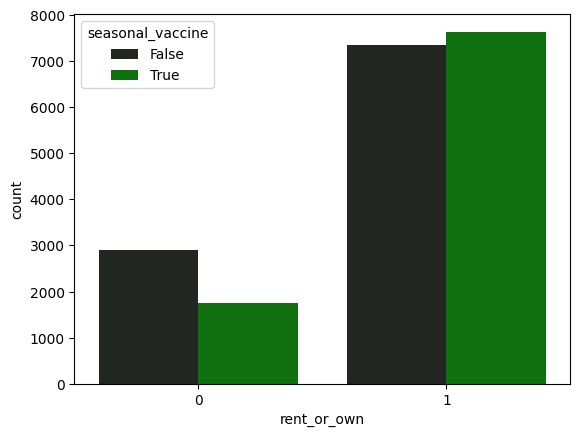

In [90]:
rent_map = {
    "Rent": 0,
    "Own": 1
}
df.rent_or_own = df.rent_or_own.map(rent_map)
sns.countplot(df, x="rent_or_own", hue='seasonal_vaccine', palette='dark:green');

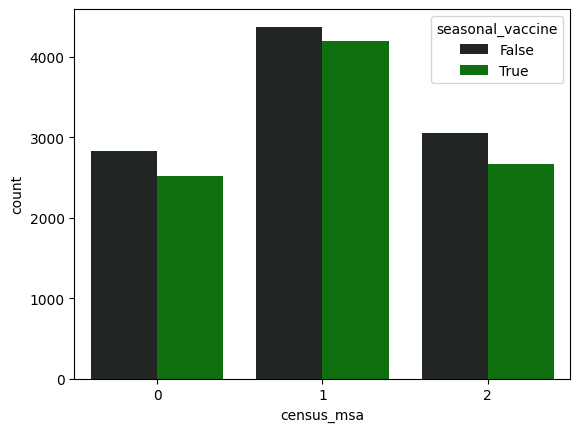

In [91]:
df.census_msa.unique()
census_map = {
    "Non-MSA": 0,
    "MSA, Not Principle  City": 1,
    "MSA, Principle City": 2
}
df.census_msa = df.census_msa.map(census_map)
sns.countplot(df, x="census_msa", hue='seasonal_vaccine', palette='dark:green');

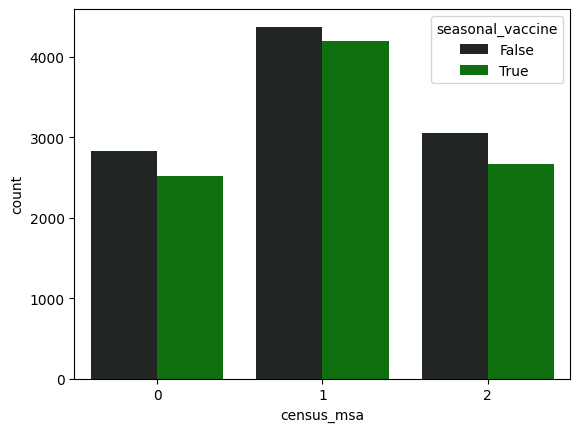

In [92]:
# now its much better
df.dtypes[df.dtypes == 'O']
sns.countplot(df, x="census_msa", hue='seasonal_vaccine', palette='dark:green');

In [93]:
df.employment_status.unique()
emp_map = {"Not in Labor Force": "NLF", 
           "Unemployed": "UE", 
           "Employed": "E"}
df.employment_status = df.employment_status.map(emp_map)

In [94]:
# update binary columns
binary_cols = [col for col in df.columns if \
                df[col].dtype != 'bool' and \
                df[col].nunique() == 2 and \
                sorted(df[col].unique().tolist()) == [0, 1]]

print(binary_cols)
df[binary_cols] = df[binary_cols].astype(bool)
binary_cols = df.dtypes[df.dtypes == 'bool'].index.values

['sex', 'marital_status', 'rent_or_own']


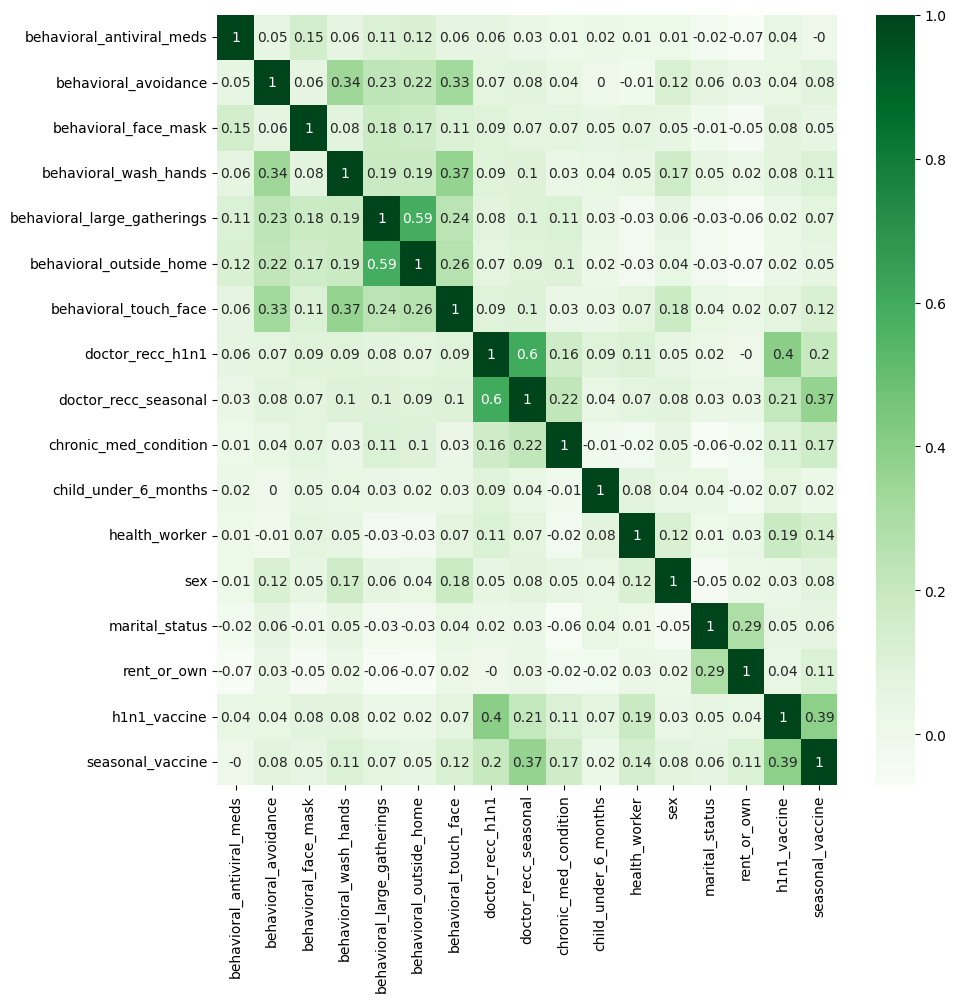

In [95]:
corr = df[binary_cols].corr(method='kendall').round(2)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='Greens', ax=ax);

In [96]:
# convert floats to ints as floating point doesn't appear here
floats = df.dtypes[df.dtypes == 'float64'].index.values
ints = df.dtypes[df.dtypes == 'int64'].index.values
df[floats] = df[floats].astype(np.uint8)
df[ints] = df[ints].astype(np.uint8)

In [97]:
df.dtypes

h1n1_concern                    uint8
h1n1_knowledge                  uint8
behavioral_antiviral_meds        bool
behavioral_avoidance             bool
behavioral_face_mask             bool
behavioral_wash_hands            bool
behavioral_large_gatherings      bool
behavioral_outside_home          bool
behavioral_touch_face            bool
doctor_recc_h1n1                 bool
doctor_recc_seasonal             bool
chronic_med_condition            bool
child_under_6_months             bool
health_worker                    bool
opinion_h1n1_vacc_effective     uint8
opinion_h1n1_risk               uint8
opinion_h1n1_sick_from_vacc     uint8
opinion_seas_vacc_effective     uint8
opinion_seas_risk               uint8
opinion_seas_sick_from_vacc     uint8
age_group                       uint8
education                       uint8
race                           object
sex                              bool
income_poverty                  uint8
marital_status                   bool
rent_or_own 

In [98]:
categorical_cols = df.dtypes[df.dtypes == 'O'].index.values
numerical_cols = df.dtypes[df.dtypes == 'uint8'].index.values

In [116]:
categorical_cols

array(['race', 'employment_status', 'hhs_geo_region'], dtype=object)

<Axes: xlabel='h1n1_vaccine', ylabel='h1n1_concern'>

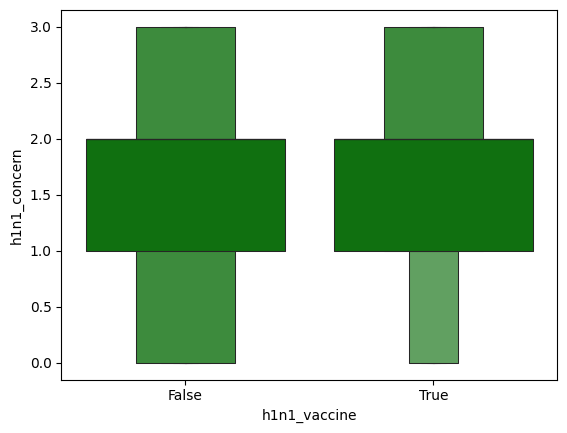

In [99]:
sns.boxenplot(df, y="h1n1_concern", x="h1n1_vaccine", color='green')

<Axes: xlabel='h1n1_vaccine', ylabel='h1n1_knowledge'>

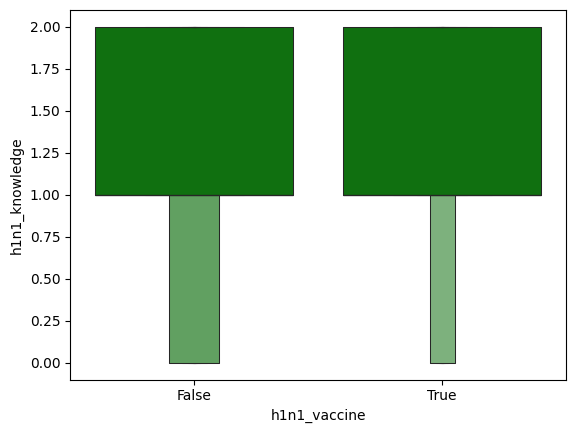

In [100]:
sns.boxenplot(df, y="h1n1_knowledge", x="h1n1_vaccine", color='green')

<Axes: xlabel='h1n1_vaccine', ylabel='opinion_h1n1_risk'>

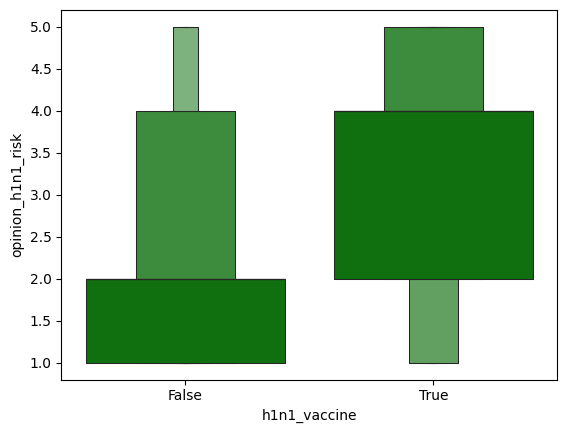

In [101]:
sns.boxenplot(df, y="opinion_h1n1_risk", x="h1n1_vaccine", color='green')

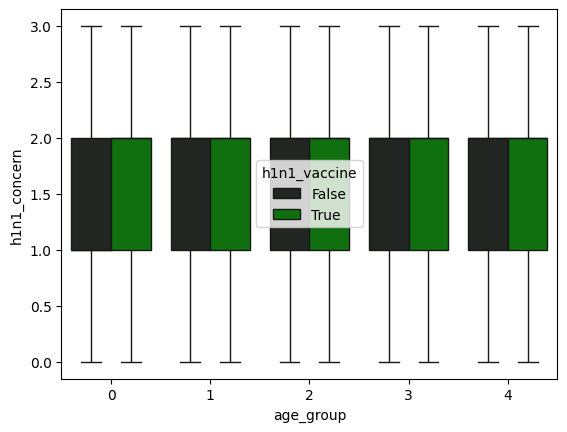

In [102]:
sns.boxplot(df, x="age_group", y="h1n1_concern", palette='dark:green', hue="h1n1_vaccine");

<Axes: xlabel='race', ylabel='seasonal_vaccine'>

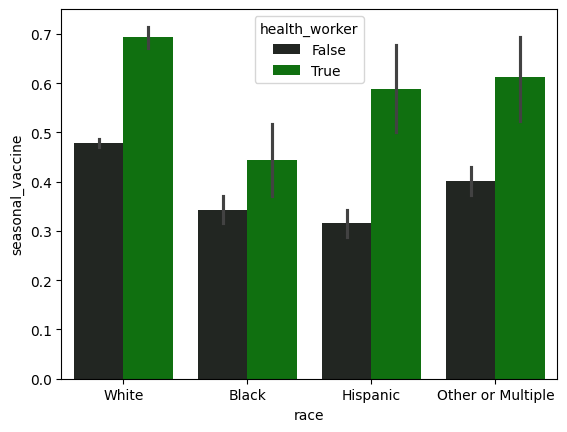

In [103]:
sns.barplot(df, x="race", y="seasonal_vaccine", palette='dark:green', hue='health_worker')

In [104]:
df[binary_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 19642 entries, 0 to 26706
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   behavioral_antiviral_meds    19642 non-null  bool 
 1   behavioral_avoidance         19642 non-null  bool 
 2   behavioral_face_mask         19642 non-null  bool 
 3   behavioral_wash_hands        19642 non-null  bool 
 4   behavioral_large_gatherings  19642 non-null  bool 
 5   behavioral_outside_home      19642 non-null  bool 
 6   behavioral_touch_face        19642 non-null  bool 
 7   doctor_recc_h1n1             19642 non-null  bool 
 8   doctor_recc_seasonal         19642 non-null  bool 
 9   chronic_med_condition        19642 non-null  bool 
 10  child_under_6_months         19642 non-null  bool 
 11  health_worker                19642 non-null  bool 
 12  sex                          19642 non-null  bool 
 13  marital_status               19642 non-null  bool 


In [123]:
feat = df.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
target_h1n1 = df.h1n1_vaccine
target_seasonal = df.seasonal_vaccine
feat_ohe = pd.get_dummies(feat, columns=categorical_cols)



In [106]:
feat_ohe.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'sex', 'income_poverty', 'marital_status', 'rent_or_own',
       'census_msa', 'household_adults', 'household_children', 'race_Black',
       'race_Hispanic', 'race_Other or Multiple', 'race_White',
       'employment_status_E', 'employment_status_NLF', 'employment_status_UE',
       'hhs_geo_region_atmpeygn', 'hhs_geo_region_bhuqouqj',
       'hhs_geo_region_dqpwygqj', 'hhs_geo_region_fpwskwrf',
       'hhs_geo_

In [107]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [108]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score

In [109]:
X_train, X_test, y_train, y_test = train_test_split(feat_ohe, target_h1n1, test_size=0.4,stratify=target_h1n1, random_state=314)

In [112]:
df['opinion_seas_vacc_effective'].value_counts()

opinion_seas_vacc_effective
4    8906
5    7603
2    1638
1     822
3     673
Name: count, dtype: int64

In [ ]:
xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.4,
    gamma=1.0,
    eta=0.04,
    objective='binary:logistic',
    eval_metric='auc',
    n_jobs=-1,
      random_state=314,
    tree_method='hist'   # быстрее на CPU
)
xgb.fit(X_train, y_train)
y_pred_xgboost = xgb.predict(X_test)
print(f"F1:{f1_score(y_test, y_pred_xgboost):.3f}")

F1:0.560


In [115]:
y_proba = xgb.predict_proba(X_test)[:, 1]
ths = np.linspace(0.1, 0.9, 100)
f1s = [f1_score(y_test, (y_proba >= t).astype(int)) for t in ths]
best_t = ths[int(np.argmax(f1s))]
print("Best threshold:", best_t, "F1:", max(f1s), "AUC:", roc_auc_score(y_test, y_proba, average="macro"))

Best threshold: 0.35858585858585856 F1: 0.613759479956663 AUC: 0.8396014826356919


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from optuna.pruners import MedianPruner
from catboost import CatBoostClassifier
import numpy as np


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=314)
pruner = MedianPruner(n_warmup_steps=3)

def objective(trial):
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'GPU',          
        'devices': '0',
        'bootstrap_type': 'Bayesian',
        'border_count': 96,
        'allow_writing_files': False,
        'verbose': False,
        'early_stopping_rounds': 150,
        'gpu_ram_part': 0.9,

        # подбираемые
        'iterations': trial.suggest_int('iterations', 250, 600),
        'depth': 4,
        'learning_rate': 0.03,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 10),
        'random_strength': trial.suggest_float('random_strength', 0.5, 1.5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 0.6),
        'random_state': 314,
    }

    scores = []
    for tr_idx, va_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = CatBoostClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            verbose=False
        )
        proba = model.predict_proba(X_va)[:, 1]
        scores.append(roc_auc_score(y_va, proba))

    return float(np.mean(scores))

study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, timeout=300)

print("Best CV AUC:", study.best_trial.value)
print("Best params:", study.best_trial.params)

# Финальная модель на всём train и проверка на test
best_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'devices': '0',
    'bootstrap_type': 'Bayesian',
    'border_count': 96,
    'allow_writing_files': False,
    'verbose': False,
    'early_stopping_rounds': 150,
    'gpu_ram_part': 0.9,
    'random_state': 314,
    **study.best_trial.params
}

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
test_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
print("Test AUC:", test_auc)


[I 2025-10-22 18:04:32,005] A new study created in memory with name: no-name-82fb7cef-d0f6-4973-84ec-e800ad5e134b
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-10-22 18:05:43,138] Trial 0 finished with value: 0.8457260731045296 and parameters: {'iterations': 597, 'l2_leaf_reg': 3.282808797007343, 'random_strength': 0.5901935073041656, 'bagging_temperature': 0.4001940328518169}. Best is trial 0 with value: 0.8457260731045296.
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-10-22 18:05:50,149] Trial 1 finished with value: 0.8452805284092971 and parameters: {'iterations': 261, 'l2_leaf_reg': 5.721777327687223, 'random_strength': 0.7073194157065428, 'bag

Best CV AUC: 0.8467178315514312
Best params: {'iterations': 471, 'l2_leaf_reg': 8.88580194587289, 'random_strength': 1.373000481465734, 'bagging_temperature': 0.021070088637935913}
Test AUC: 0.8449310429455936


Тут уже работаем с другой переменной

In [127]:
X_train, X_test, y_train, y_test = train_test_split(feat_ohe, target_seasonal, test_size=0.4,stratify=target_seasonal, random_state=314)

In [128]:
xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.4,
    gamma=1.0,
    eta=0.04,
    objective='binary:logistic',
    eval_metric='auc',
    n_jobs=-1,
      random_state=314,
    tree_method='hist'   # быстрее на CPU
)
xgb.fit(X_train, y_train)
y_pred_xgboost = xgb.predict(X_test)
print(f"F1:{f1_score(y_test, y_pred_xgboost):.3f}")

F1:0.774


In [129]:
y_proba = xgb.predict_proba(X_test)[:, 1]
ths = np.linspace(0.1, 0.9, 100)
f1s = [f1_score(y_test, (y_proba >= t).astype(int)) for t in ths]
best_t = ths[int(np.argmax(f1s))]
print("Best threshold:", best_t, "F1:", max(f1s), "AUC:", roc_auc_score(y_test, y_proba, average="macro"))

Best threshold: 0.3424242424242424 F1: 0.7845424717462632 AUC: 0.8607996099463676


In [130]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=314)
pruner = MedianPruner(n_warmup_steps=3)

def objective(trial):
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'GPU',          
        'devices': '0',
        'bootstrap_type': 'Bayesian',
        'border_count': 96,
        'allow_writing_files': False,
        'verbose': False,
        'early_stopping_rounds': 150,
        'gpu_ram_part': 0.9,

        # подбираемые
        'iterations': trial.suggest_int('iterations', 250, 600),
        'depth': 4,
        'learning_rate': 0.03,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 10),
        'random_strength': trial.suggest_float('random_strength', 0.5, 1.5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 0.6),
        'random_state': 314,
    }

    scores = []
    for tr_idx, va_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        model = CatBoostClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            verbose=False
        )
        proba = model.predict_proba(X_va)[:, 1]
        scores.append(roc_auc_score(y_va, proba))

    return float(np.mean(scores))

study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, timeout=300)

print("Best CV AUC:", study.best_trial.value)
print("Best params:", study.best_trial.params)

# Финальная модель на всём train и проверка на test
best_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'devices': '0',
    'bootstrap_type': 'Bayesian',
    'border_count': 96,
    'allow_writing_files': False,
    'verbose': False,
    'early_stopping_rounds': 150,
    'gpu_ram_part': 0.9,
    'random_state': 314,
    **study.best_trial.params
}

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
test_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
print("Test AUC:", test_auc)

[I 2025-10-22 19:17:50,402] A new study created in memory with name: no-name-0baec9b8-deaa-487f-8106-f9fd62d4e1e9
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-10-22 19:19:01,628] Trial 0 finished with value: 0.8599247223191461 and parameters: {'iterations': 551, 'l2_leaf_reg': 6.54788046286583, 'random_strength': 1.13741256593838, 'bagging_temperature': 0.28394656227021653}. Best is trial 0 with value: 0.8599247223191461.
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-10-22 19:19:13,361] Trial 1 finished with value: 0.8608446638625388 and parameters: {'iterations': 424, 'l2_leaf_reg': 3.4841297688465014, 'random_strength': 1.3293979458170089, 'bagg

Best CV AUC: 0.8608446638625388
Best params: {'iterations': 424, 'l2_leaf_reg': 3.4841297688465014, 'random_strength': 1.3293979458170089, 'bagging_temperature': 0.5006342905680488}
Test AUC: 0.8630860461688981
